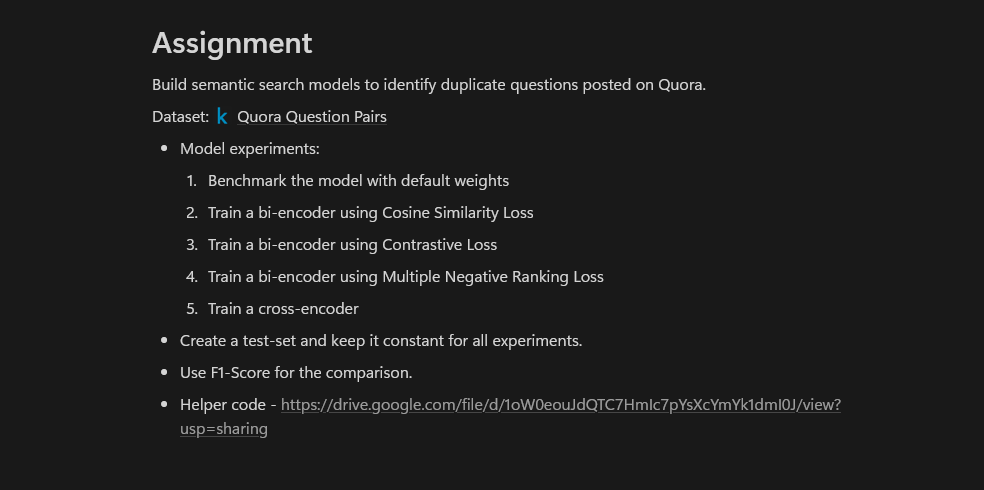

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sentence_transformers.readers import InputExample
from sentence_transformers import SentenceTransformer, util
from torch.utils.data import DataLoader
from sentence_transformers import models, losses
import torch
import torch.nn as nn
from sklearn.metrics import f1_score, precision_recall_curve
import numpy as np
import os
import itertools

# --- Load and Prepare Data ---
DATA_PATH = r'C:\Users\laava\Desktop\sem 7\NLP\train.csv'  
if not os.path.exists(DATA_PATH):
    print("Error: Dataset not found. Please download 'train.csv' from the Kaggle competition.")
    # You need to manually download the file from https://www.kaggle.com/competitions/quora-question-pairs/data
else:
    df = pd.read_csv(DATA_PATH)
    # Drop rows with any missing values
    df.dropna(inplace=True)

    # --- Create a constant test set ---
    # We will use this set to evaluate all models to ensure fair comparison.
    # Stratify to maintain the same proportion of duplicate questions in the test set.
    train_df, test_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df['is_duplicate'])
    print(f"Training set size: {len(train_df)}")
    print(f"Test set size: {len(test_df)}")

    # Prepare data for Sentence-Transformers
    train_samples_bi = []
    for _, row in train_df.iterrows():
        train_samples_bi.append(InputExample(texts=[row['question1'], row['question2']], label=float(row['is_duplicate'])))

    # DataLoader for bi-encoders
    train_dataloader_bi = DataLoader(train_samples_bi, shuffle=True, batch_size=32)

    # Prepare data for Cross-encoder (different format)
    train_samples_cross = []
    for _, row in train_df.iterrows():
        train_samples_cross.append(InputExample(texts=[row['question1'], row['question2']], label=int(row['is_duplicate'])))

    # DataLoader for cross-encoder
    train_dataloader_cross = DataLoader(train_samples_cross, shuffle=True, batch_size=32)

    # --- Evaluation function for bi-encoders ---
    def evaluate_bi_encoder(model, test_df):
        print("Evaluating bi-encoder...")
        # Encode all unique questions
        unique_questions = pd.Series(test_df['question1']).append(pd.Series(test_df['question2'])).unique()
        embeddings = model.encode(unique_questions, convert_to_tensor=True, show_progress_bar=False)
        question_to_embedding = {q: emb for q, emb in zip(unique_questions, embeddings)}

        y_true = test_df['is_duplicate'].values
        y_scores = []
        for _, row in test_df.iterrows():
            emb1 = question_to_embedding[row['question1']]
            emb2 = question_to_embedding[row['question2']]
            y_scores.append(util.cos_sim(emb1, emb2).item())

        # Find the optimal F1-score threshold
        precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
        best_f1_score = np.max(f1_scores)
        best_threshold = thresholds[np.argmax(f1_scores)]

        return best_f1_score, best_threshold

    # --- Evaluation function for cross-encoders ---
    def evaluate_cross_encoder(model, test_df):
        print("Evaluating cross-encoder...")
        y_true = test_df['is_duplicate'].values
        # Prepare data for batching
        test_sentences = list(zip(test_df['question1'], test_df['question2']))
        # Predict scores for all pairs
        y_scores = model.predict(test_sentences, show_progress_bar=False)

        # Find the optimal F1-score threshold
        precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
        best_f1_score = np.max(f1_scores)
        best_threshold = thresholds[np.argmax(f1_scores)]

        return best_f1_score, best_threshold

    results = {}


Training set size: 363858
Test set size: 40429


In [2]:
# 1. Benchmark the model with default weights
print("\n--- Running Experiment 1: Benchmark ---")
model_benchmark = SentenceTransformer('all-MiniLM-L6-v2')
f1_benchmark, threshold_benchmark = evaluate_bi_encoder(model_benchmark, test_df)
results['Benchmark'] = f1_benchmark
print(f"✅ F1-Score (Benchmark): {f1_benchmark:.4f} at threshold {threshold_benchmark:.4f}")


--- Running Experiment 1: Benchmark ---
Evaluating bi-encoder...


C:\Users\laava\AppData\Local\Temp\ipykernel_21160\2990006950.py:51: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  unique_questions = pd.Series(test_df['question1']).append(pd.Series(test_df['question2'])).unique()


✅ F1-Score (Benchmark): 0.7347 at threshold 0.7244


In [8]:
## 2. Train a bi-encoder using Cosine Similarity Loss 
print("\n--- Running Experiment 2: Cosine Similarity Loss ---")
model_cos = SentenceTransformer('all-MiniLM-L6-v2')
loss_cos = losses.CosineSimilarityLoss(model=model_cos)

# Pass the DataLoader and the loss function as a tuple inside a list
train_objectives_cos = [(train_dataloader_bi, loss_cos)]

model_cos.fit(
    train_objectives=train_objectives_cos,
    epochs=1,
    optimizer_params={'lr': 2e-5},
    show_progress_bar=True
)

f1_cos, threshold_cos = evaluate_bi_encoder(model_cos, test_df)
results['CosineSimilarityLoss'] = f1_cos
print(f"✅ F1-Score (Cosine Similarity Loss): {f1_cos:.4f} at threshold {threshold_cos:.4f}")


--- Running Experiment 2: Cosine Similarity Loss ---


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.225700
1000,0.190100
1500,0.162100
2000,0.151200
2500,0.145800
3000,0.139700
3500,0.136700
4000,0.136200
4500,0.131900
5000,0.130000


Evaluating bi-encoder...


C:\Users\laava\AppData\Local\Temp\ipykernel_21160\2990006950.py:51: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  unique_questions = pd.Series(test_df['question1']).append(pd.Series(test_df['question2'])).unique()


✅ F1-Score (Cosine Similarity Loss): 0.8165 at threshold 0.5628


In [9]:
## 3. Train a bi-encoder using Contrastive Loss 
print("\n--- Running Experiment 3: Contrastive Loss ---")
model_contrastive = SentenceTransformer('all-MiniLM-L6-v2')
loss_contrastive = losses.ContrastiveLoss(model=model_contrastive, margin=0.5)

# Create the training objective tuple
train_objectives_contrastive = [(train_dataloader_bi, loss_contrastive)]

model_contrastive.fit(
    train_objectives=train_objectives_contrastive,
    epochs=1,
    optimizer_params={'lr': 2e-5},
    show_progress_bar=True
)

f1_contrastive, threshold_contrastive = evaluate_bi_encoder(model_contrastive, test_df)
results['ContrastiveLoss'] = f1_contrastive
print(f"✅ F1-Score (Contrastive Loss): {f1_contrastive:.4f} at threshold {threshold_contrastive:.4f}")


--- Running Experiment 3: Contrastive Loss ---


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.018200
1000,0.017000
1500,0.016400
2000,0.015100
2500,0.014600
3000,0.014200
3500,0.013700
4000,0.013500
4500,0.013600
5000,0.013300


Evaluating bi-encoder...


C:\Users\laava\AppData\Local\Temp\ipykernel_21160\2990006950.py:51: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  unique_questions = pd.Series(test_df['question1']).append(pd.Series(test_df['question2'])).unique()


✅ F1-Score (Contrastive Loss): 0.8444 at threshold 0.7839


In [10]:
# 4. Train a bi-encoder using Multiple Negative Ranking Loss 
print("\n--- Running Experiment 4: Multiple Negative Ranking Loss ---")
model_mnr = SentenceTransformer('all-MiniLM-L6-v2')
loss_mnr = losses.MultipleNegativesRankingLoss(model=model_mnr)

# Note: The data loader for MNR is slightly different, it expects a list of InputExamples
train_samples_mnr = []
for _, row in train_df.iterrows():
    train_samples_mnr.append(InputExample(texts=[row['question1'], row['question2']]))

train_dataloader_mnr = DataLoader(train_samples_mnr, shuffle=True, batch_size=32)

model_mnr.fit(
    train_dataloader_mnr,
    loss=loss_mnr,
    epochs=1,
    optimizer_params={'lr': 2e-5},
    show_progress_bar=True
)

f1_mnr, threshold_mnr = evaluate_bi_encoder(model_mnr, test_df)
results['MultipleNegativeRankingLoss'] = f1_mnr
print(f"✅ F1-Score (Multiple Negative Ranking Loss): {f1_mnr:.4f} at threshold {threshold_mnr:.4f}")


--- Running Experiment 4: Multiple Negative Ranking Loss ---


TypeError: FitMixin.fit() got an unexpected keyword argument 'loss'

In [ ]:
# 5. Train a Cross-encoder 
print("\n--- Running Experiment 5: Cross-encoder ---")
# Use a pre-trained cross-encoder model
model_cross = SentenceTransformer('cross-encoder/stsb-distilroberta-base')

# The loss function is automatically handled by the CrossEncoder class (BCEWithLogitsLoss)
# It requires the data to be formatted with labels as 0 or 1, which we did earlier.
model_cross.fit(
    train_dataloader_cross,
    epochs=1,
    optimizer_params={'lr': 2e-5},
    show_progress_bar=True
)

f1_cross, threshold_cross = evaluate_cross_encoder(model_cross, test_df)
results['Cross-encoder'] = f1_cross
print(f"✅ F1-Score (Cross-encoder): {f1_cross:.4f} at threshold {threshold_cross:.4f}")

In [ ]:
# Final Comparison 
print("\n--- Final Results ---")
for model_name, f1_score in results.items():
    print(f"**{model_name.ljust(30)}**: F1-Score = **{f1_score:.4f}**")

# You can also add a plot for visualization
import matplotlib.pyplot as plt

model_names = list(results.keys())
f1_scores = list(results.values())

plt.figure(figsize=(10, 6))
plt.bar(model_names, f1_scores, color=['blue', 'green', 'orange', 'purple', 'red'])
plt.xlabel("Model Type")
plt.ylabel("F1-Score")
plt.title("Comparison of F1-Scores for Duplicate Question Detection")
plt.ylim(min(f1_scores) * 0.9, 1.0)
plt.grid(axis='y', linestyle='--')
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.show()